<a href="https://colab.research.google.com/github/irgishalby/ecommerce-sales-analytics-ml/blob/main/pricing_health_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT PIPELINE – REVENUE / PROFIT PREDICTION

0. Define target
   Decide what to predict:
   - Optimal-Price-Deviation
   - Platform-Sensitivity-Score (later)

1. Load data

2. Clean data

3. Feature engineering

4. EDA

5. Label

6. Modeling

7. Evaluate & interpret

# 1. Load

In [59]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlock-profits-with-e-commerce-sales-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'unlock-profits-with-e-commerce-sales-data' dataset.
Path to dataset files: /kaggle/input/unlock-profits-with-e-commerce-sales-data


In [60]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(path, "May-2022.csv"))

In [61]:
df.head()

,index,Sku,Style Id,Catalog,Category,Weight,TP,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
0,0,Os206_3141_S,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
1,1,Os206_3141_M,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
2,2,Os206_3141_L,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
3,3,Os206_3141_XL,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295
4,4,Os206_3141_2XL,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295


# 2. Cleaning

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           1330 non-null   int64 
 1   Sku             1330 non-null   object
 2   Style Id        1330 non-null   object
 3   Catalog         1330 non-null   object
 4   Category        1330 non-null   object
 5   Weight          1330 non-null   object
 6   TP              1330 non-null   object
 7   MRP Old         1330 non-null   object
 8   Final MRP Old   1330 non-null   object
 9   Ajio MRP        1330 non-null   object
 10  Amazon MRP      1330 non-null   object
 11  Amazon FBA MRP  1330 non-null   object
 12  Flipkart MRP    1330 non-null   object
 13  Limeroad MRP    1330 non-null   object
 14  Myntra MRP      1330 non-null   object
 15  Paytm MRP       1330 non-null   object
 16  Snapdeal MRP    1330 non-null   object
dtypes: int64(1), object(16)
memory usage: 176.8+ KB


In [63]:
price_cols = [
    'MRP Old', 'Final MRP Old', 'Ajio MRP', 'Amazon MRP',
    'Amazon FBA MRP', 'Flipkart MRP', 'Limeroad MRP',
    'Myntra MRP', 'Paytm MRP', 'Snapdeal MRP'
]

for col in price_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [64]:
def clean_weight(x):
    if isinstance(x, str) and '-' in x:
        low, high = x.split('-')
        return (float(low) + float(high)) / 2
    return x

df['Weight'] = df['Weight'].apply(clean_weight)
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

In [65]:
df = df.dropna(subset=price_cols)

In [66]:
df.isna().sum()

,0
index,0
Sku,0
Style Id,0
Catalog,0
Category,0
Weight,72
TP,0
MRP Old,0
Final MRP Old,0
Ajio MRP,0


In [67]:
df['Weight'] = df['Weight'].fillna(df['Weight'].median())

In [68]:
df.isna().sum()

,0
index,0
Sku,0
Style Id,0
Catalog,0
Category,0
Weight,0
TP,0
MRP Old,0
Final MRP Old,0
Ajio MRP,0


# 3. Feature Engineering

In [69]:
competitor_cols = [
    'Ajio MRP', 'Amazon MRP', 'Amazon FBA MRP',
    'Flipkart MRP', 'Limeroad MRP',
    'Myntra MRP', 'Paytm MRP', 'Snapdeal MRP'
]

df['market_price'] = df[competitor_cols].median(axis=1)

In [70]:
df['our_price'] = df['Final MRP Old']

In [71]:
df['price_deviation'] = (df['our_price'] - df['market_price']) / df['market_price']


In [72]:
df['discount_pct'] = (df['MRP Old'] - df['Final MRP Old']) / df['MRP Old']

In [73]:
df['comp_price_spread'] = (df[competitor_cols].max(axis=1) - df[competitor_cols].min(axis=1))

# 4. EDA
Analyze the 'price_deviation' feature by visualizing its distribution, comparing its distribution across different 'Category' values, investigating its relationship with 'Weight', and examining its relationship with 'discount_pct'.

## Analyze Price Deviation Distribution

### Subtask:
Visualize the distribution of the 'price_deviation' feature to understand its spread, central tendency, and identify if products are generally overpriced or underpriced relative to the market.


**Reasoning**:
To visualize the distribution of 'price_deviation', I will import the necessary plotting libraries, create a histogram of the 'price_deviation' column, and add appropriate labels and a title for better understanding.



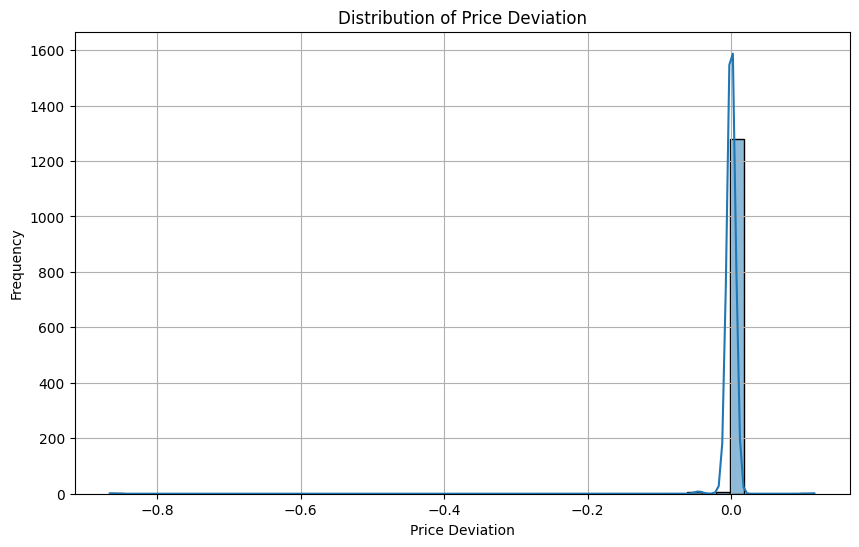

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['price_deviation'], kde=True, bins=50)
plt.title('Distribution of Price Deviation')
plt.xlabel('Price Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Compare Price Deviation by Category

### Subtask:
Group the data by 'Category' and analyze the distribution of 'price_deviation' for each category to identify if certain categories consistently exhibit higher or lower price deviations.


**Reasoning**:
To compare the distribution of 'price_deviation' across different product categories, I will create a box plot using seaborn, which effectively displays the median, quartiles, and outliers for each category.



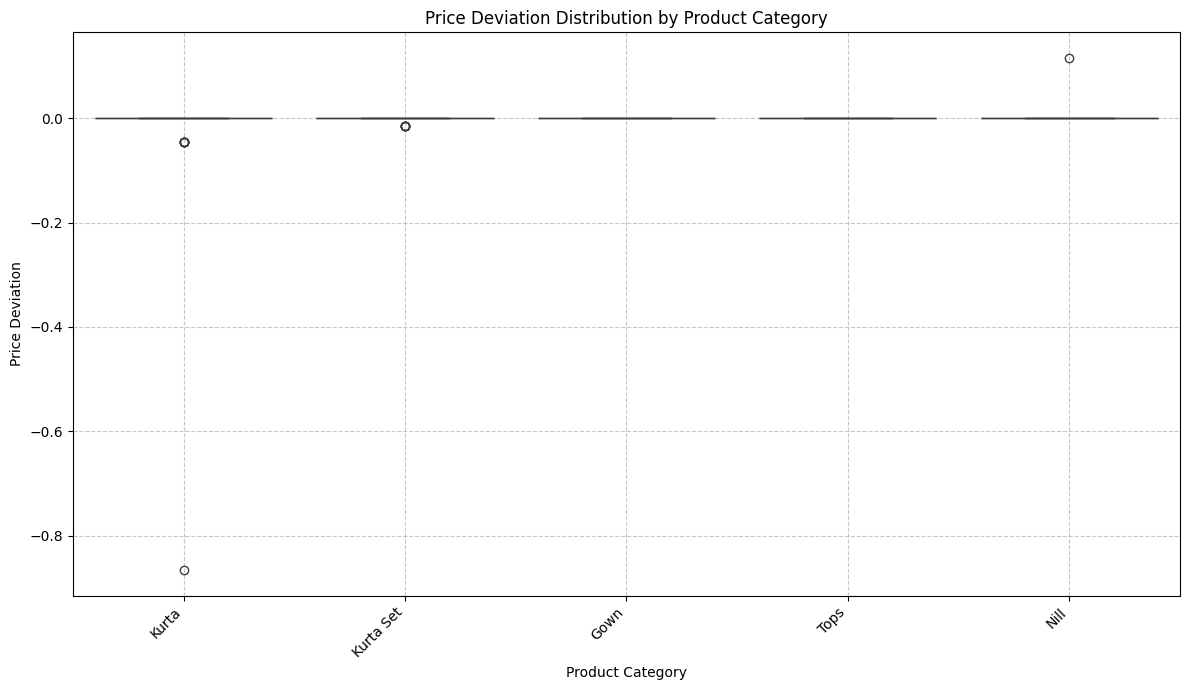

In [75]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Category', y='price_deviation', data=df)
plt.title('Price Deviation Distribution by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Price Deviation')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Investigate Relationship between Price Deviation and Weight

### Subtask:
Examine the relationship between 'price_deviation' and 'Weight' to determine if heavier or lighter items tend to have different pricing strategies or market positioning.

## Investigate Relationship between Price Deviation and Weight

### Subtask:
Examine the relationship between 'price_deviation' and 'Weight' to determine if heavier or lighter items tend to have different pricing strategies or market positioning.

**Reasoning**:
To visualize the relationship between 'price_deviation' and 'Weight', I will use a scatter plot, which is suitable for showing the correlation between two numerical variables. Adding a regression line will help in understanding the trend.



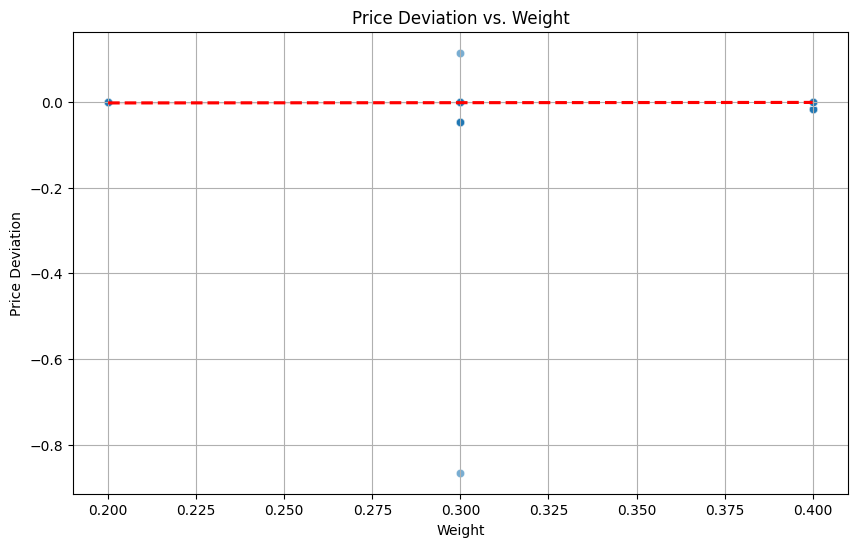

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Weight', y='price_deviation', data=df, alpha=0.6)
sns.regplot(x='Weight', y='price_deviation', data=df, scatter=False, color='red', line_kws={'linestyle':'--'})
plt.title('Price Deviation vs. Weight')
plt.xlabel('Weight')
plt.ylabel('Price Deviation')
plt.grid(True)
plt.show()

## Examine Relationship between Price Deviation and Discount Percentage

### Subtask:
Analyze how 'price_deviation' relates to 'discount_pct' to identify if higher discounts lead to a different pricing strategy or market positioning relative to competitors.

**Reasoning**:
To visualize the relationship between 'price_deviation' and 'discount_pct', I will use a scatter plot, which is suitable for showing the correlation between two numerical variables. Adding a regression line will help in understanding the trend.



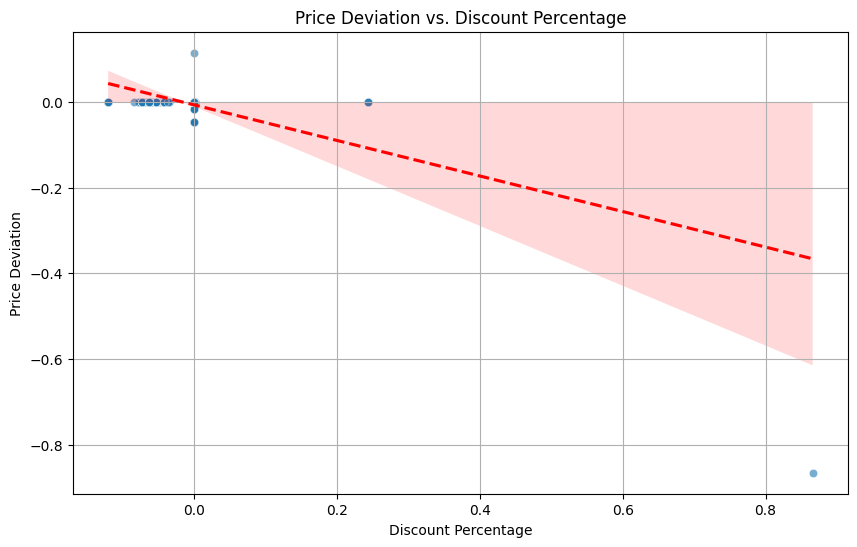

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_pct', y='price_deviation', data=df, alpha=0.6)
sns.regplot(x='discount_pct', y='price_deviation', data=df, scatter=False, color='red', line_kws={'linestyle':'--'})
plt.title('Price Deviation vs. Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Price Deviation')
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings
*   **Overall Price Deviation Distribution:** A histogram with a Kernel Density Estimate (KDE) was generated to visualize the distribution of `price_deviation`, providing an initial understanding of its spread and central tendency, indicating whether products are generally overpriced or underpriced relative to the market.
*   **Price Deviation by Category:** A box plot was created to display the distribution of `price_deviation` across different product categories, allowing for comparison and identification of categories with consistently higher or lower price deviations.
*   **Relationship with Weight:** A scatter plot with a regression line was used to examine the relationship between `price_deviation` and `Weight`, which helps in understanding if heavier or lighter items exhibit different pricing strategies or market positioning.
*   **Relationship with Discount Percentage:** A scatter plot with a regression line was generated to analyze the relationship between `price_deviation` and `discount_pct`, aiding in determining if higher discounts correlate with specific patterns in price deviation.

### Insights or Next Steps
*   Further analysis is needed to interpret the visual patterns from the generated plots (e.g., skewness, outliers in price deviation, specific categories with significant deviations, correlation direction and strength between price deviation and weight/discount percentage) to derive concrete business insights.
*   Quantifying the relationships (e.g., calculating correlation coefficients for `price_deviation` vs. `Weight` and `price_deviation` vs. `discount_pct`) and identifying specific categories with statistically significant `price_deviation` differences would provide more actionable intelligence.


# 5. Labeling

In [81]:
df['price_label'] = df['price_deviation'].apply(
    lambda x: 1 if abs(x) <= 0.02 else 0
)

df['price_label'].value_counts(normalize=True)

,proportion
price_label,
1,0.993813
0,0.006187


# 6. Modeling

In [84]:
features = [
    'Weight',
    'TP',
    'discount_pct',
    'comp_price_spread'
]

X = df[features]
y = df['price_label']

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# 7. Evaluate

In [89]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       259

    accuracy                           1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259

